# Jane Stree 2020 EDA

Notes from EDA
 - There appears to be different regime, as exhibited in the number of opportunities (rows) plot in Section 1.
   - $\to$ consider explicit feature engineering to capture this point
 - Per sample weight should be always used in training, as observed in Section 2.1
   - But note, zero weight means dropping that row effectively. Rethinking this point
 - Response at different horizon, resp_1 through resp_4, may be useful as disucssed in Section 2.1
   - Consider forming an weighted average of resp_1 through resp_4 as traing target
     - It may adds noise in a meaningful way, so as to help reducing overfitting
     - It may reflect truth better than resp itself
     - In the same vein, consider combining all 5 responses


## 0. Load data

In [1]:
import os, sys
import gc
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dtable
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
plt.style.use('dark_background') #plt.style.use('default')

# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

from tabulate import tabulate
pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

pd.set_option('display.max_columns', 200)

In [55]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
ddir='~/learn/kaggle/Data/JaneStreet20' # local
#ddir='../input/jane-street-market-prediction' # kaggle

# using datatable for faster loading
data = dtable.fread(os.path.join(ddir,"train.csv")).to_pandas()
features = pd.read_csv(os.path.join(ddir,"features.csv"))

gc.collect();

## 1. Time characterization

Columns 'date' and 'ts_id' indicate dates and time sequence.
 - Number of signals are unevenly distributed over days.
 - Signals may be generated at per second or sub-second scale, based on max count per day


Max #/day= 18884 ,  #/sec 0.21856481481481482
Median #/day= 4353.5 ,  #/sec 0.050387731481481485


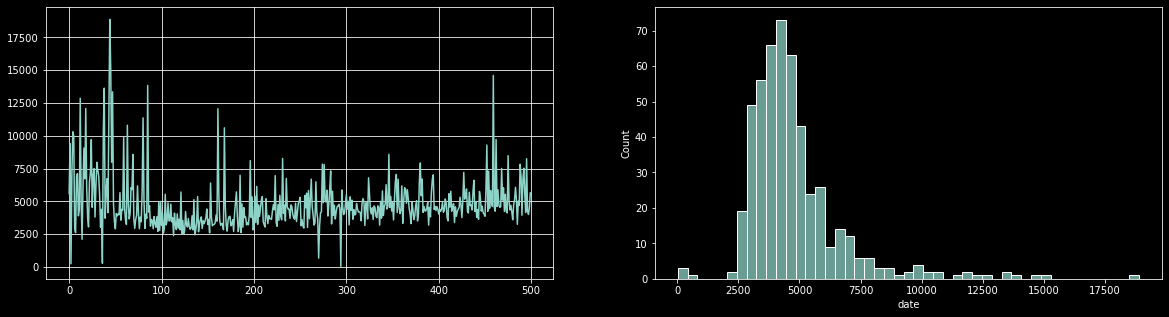

In [7]:
# nnumber opportunities per day
nOpPD=data['date'].value_counts(sort=False)  # nnumber opportunities per day
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
nOpPD.plot(ax=ax[0],grid=True);
sns.histplot(nOpPD,ax=ax[1]);

print('Max #/day=',nOpPD.max(),',  #/sec',nOpPD.max()/(24*3600))
print('Median #/day=',nOpPD.median(),',  #/sec',nOpPD.median()/(24*3600))

## 2. Responses

The score probably corresponds to PnL, and is computed in 3 steps. First,
$$ p_k = \sum_j (weight_{kj} \cdot resp_{kj} \cdot action_{kj}), $$
where $k$ index days and $j$ index ts_id. Next, with $n=|k|$ indicating the day counts
$$
t=\frac{\sum_k p_k}{\sqrt{\sum_k p^2_k}} \cdot \sqrt\frac{250}{n} 
= \sqrt{250} \frac{\frac{1}{n} \sum_k p_k}{\sqrt{\frac{\sum_k p^2_k}{n}, }}
$$
which looks like annualized Sharpe Ratio if $p_k$ is interpreted as daily returns. Finally, the utility (score) is given by
$$ u=\min (\max(t,0), 6) \sum+k p_k. $$


The interpretation of the responses and utility is
 - $resp_{kj}$ should be PnL (return) for trade $(k,j)$
 - $weight_{kj}$ should be size of trade $(k,j)$, which is already determined somehow
 - $action_{kj} \in \{0,1\}$ is the decision to be made: to trade or not to trade
 - Score is the product of SR and PnL



### 2.1. Weights

Weights are non-negative, and have a long right tail. In addition, tt has a big impact on $p_k$, hence the final score. It follows that
 - $\to$ per sample weight should be always used in training.
 
Response at all horizons are positively correlated.
 - Consider forming an weighted average of resp_1 through resp_4 as traing target
   - It may adds noise in a meaningful way, so as to help reducing overfitting
   - It may reflect truth better than resp itself
   - In the same vein, consider combining all 5 responses

In [18]:
nzWeight=data.loc[data['weight']!=0,'weight']
print('zero weights: {:.1f}%'.format((data['weight']==0).sum()/data.shape[0]*100),
      ',  non-zero weights: {:.1f}%'.format((data['weight']!=0).sum()/data.shape[0]*100),
      ',  #NaN in weights:',data['weight'].isna().sum())
print(pd.concat([data['weight'].describe(),nzWeight.describe().rename('Nonzero weight')],axis=1 ))

zero weights: 17.1% ,  non-zero weights: 82.9% ,  #NaN in weights: 0
             weight  Nonzero weight
count  2.390491e+06    1.981287e+06
mean   3.031535e+00    3.657652e+00
std    7.672794e+00    8.291001e+00
min    0.000000e+00    6.912442e-03
25%    1.617400e-01    3.786683e-01
50%    7.086770e-01    1.072844e+00
75%    2.471791e+00    3.196557e+00
max    1.672937e+02    1.672937e+02


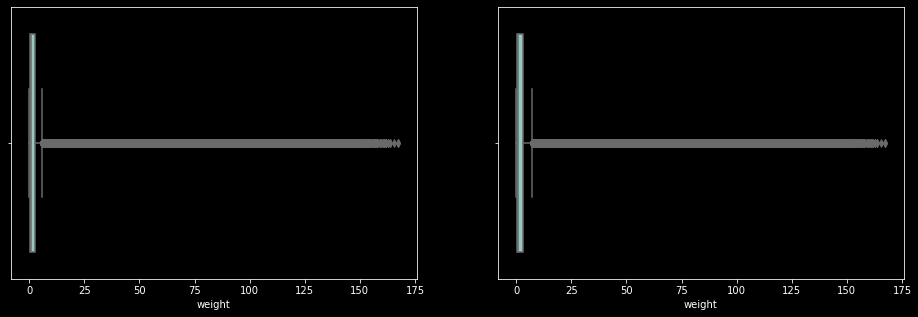

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data['weight'],ax=ax[0]);
sns.boxplot(nzWeight,ax=ax[1]);

### 2.2 Returns: resp

Column 'resp' represents returns, while 'resp_i' represent returns at different horizons

In [45]:
yy=data.loc[:,['resp']+['resp_{}'.format(ii) for ii in range(1,5)]]
print(pdtabulate(yy.describe()))
print('#NaN:')
print(yy.isna().sum(axis=0).to_frame().T)

+-------+--------------+--------------+--------------+--------------+--------------+
|       |         resp |       resp_1 |       resp_2 |       resp_3 |       resp_4 |
|-------+--------------+--------------+--------------+--------------+--------------|
| count |  2.39049e+06 |  2.39049e+06 |  2.39049e+06 |  2.39049e+06 |  2.39049e+06 |
| mean  |  0.000408311 |  0.000143497 |  0.000198075 |  0.000282418 |  0.00043502  |
| std   |  0.0269361   |  0.00893016  |  0.0123024   |  0.0190688   |  0.0329122   |
| min   | -0.549384    | -0.367504    | -0.532833    | -0.56812     | -0.598745    |
| 25%   | -0.0071579   | -0.00185916  | -0.00265504  | -0.0050307   | -0.00931042  |
| 50%   |  8.635e-05   |  4.55267e-05 |  6.92818e-05 |  0.000116473 |  0.000122258 |
| 75%   |  0.00754435  |  0.00209747  |  0.00293911  |  0.00546634  |  0.00980465  |
| max   |  0.448462    |  0.245348    |  0.294934    |  0.32656     |  0.511379    |
+-------+--------------+--------------+--------------+-----------

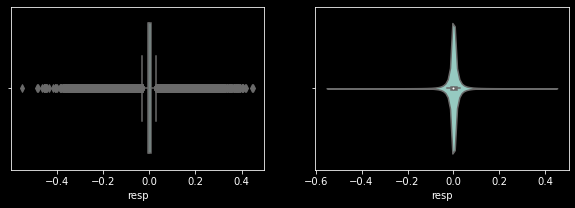

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 3))
sns.boxplot(data['resp'],ax=ax[0])
sns.violinplot(data['resp'],ax=ax[1]);

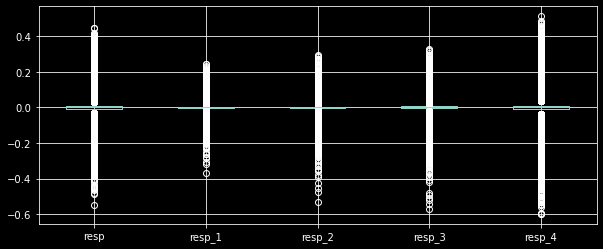

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 4))
yy.boxplot(ax=ax);

## 3. Features

The file "features.csv" contains feature vs. tag, which is bool. its meaning is unclear ???


### 3.1 Feature tags -- file "features.csv"

How to display the matrix?

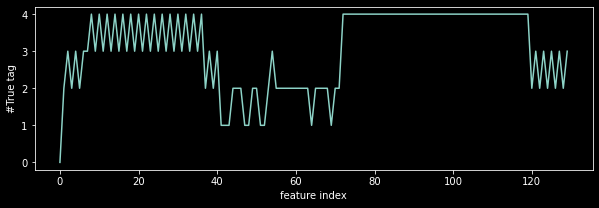

In [73]:
_, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 3))
ax.plot(features.sum(axis=1))
ax.set(xlabel='feature index', ylabel='#True tag');

### 3.2 Features


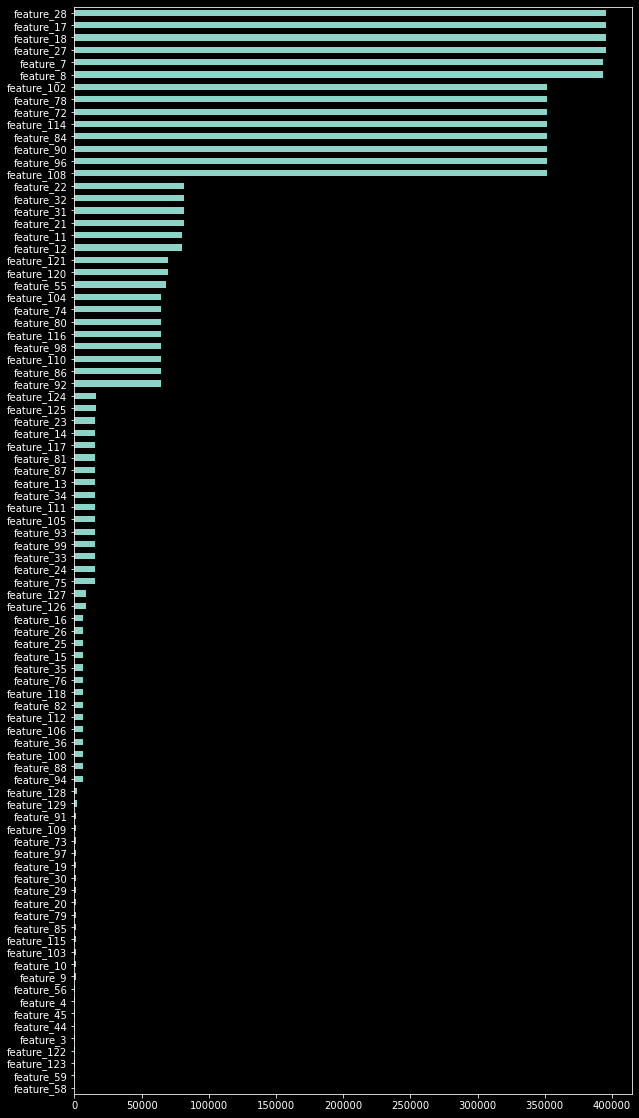

In [85]:
features = [f"feature_{x}" for x in range(130)]
null_count = data[features].isna().sum().sort_values(ascending=True)
null_count = null_count[null_count >0]
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 20) )
null_count.plot.barh(ax=ax);